# How to Deploy your NLP Model to Production as an API with Algorithmia

- Did you know that 90% of machine learning models never actually make it into production?

- This means that the topic of machine learning deployment is rarely discussed when people learn machine learning. As a result, many AI practitioners know how to create useful ML models, but they find it difficult to deploy them into production.

- Needless to say, machine learning deployment is one of the more important skills you should have if you're going to work with ML models.

***Model deployment is the process of integrating your model into an existing production environment. The model will receive input and predict an output for decision making for a specific use case.***

- For example, a model can be deployed in an e-commerce site and it can predict if a review about a specific product is positive or negative.

- Only when a model is fully integrated with the business systems, we can extract real value from its predictions. - Christopher Samiullah
- There are different ways you can deploy your machine learning model into production. But in today's article, you will learn how to deploy your NLP model into production as an API with Algorithmia.

In [7]:
# import important modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from string import punctuation 

# sklearn modules
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

# text preprocessing modules
from nltk.tokenize import word_tokenize
from cleantext import clean

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import re #regular expression


from wordcloud import WordCloud, STOPWORDS

# Download dependency
for dependency in (
    "brown",
    "names",
    "wordnet",
    "averaged_perceptron_tagger",
    "universal_tagset",
    "stopwords"
):
    nltk.download(dependency)

#nltk.download('stopwords')

import warnings
warnings.filterwarnings("ignore")
# seeding
np.random.seed(123)

[nltk_data] Downloading package brown to /Users/gabe/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package names to /Users/gabe/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.
[nltk_data] Downloading package wordnet to /Users/gabe/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/gabe/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/gabe/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package stopwords to /Users/gabe/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
# load data
data = pd.read_csv("spam.tsv", sep="\t")
# show top five rows
data.head()

,label,message,length,punct
0,ham,"Go until jurong point, crazy.. Available only ...",111,9
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6
3,ham,U dun say so early hor... U c already then say...,49,6
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2


In [11]:
# check the shape
data.shape

(5572, 4)

### Checking missing values

In [12]:
# check missing values
data.isnull().sum()

label      0
message    0
length     0
punct      0
dtype: int64

### Evaluating Class Distribution

In [13]:
# evalute class distribution
data["label"].value_counts()

label
ham     4825
spam     747
Name: count, dtype: int64

### Exploratory Data Analysis

- In this step we are going to find frequent words that are used in both legitimate and spam messages.

- The above function called collect_words() will collect all words from the dataset according to their labels (ham or spam).

- Then we can visualize frequent words by using the wordcloud Python package. We will start with messages labeled as ham (legitimate).

Total words 349132


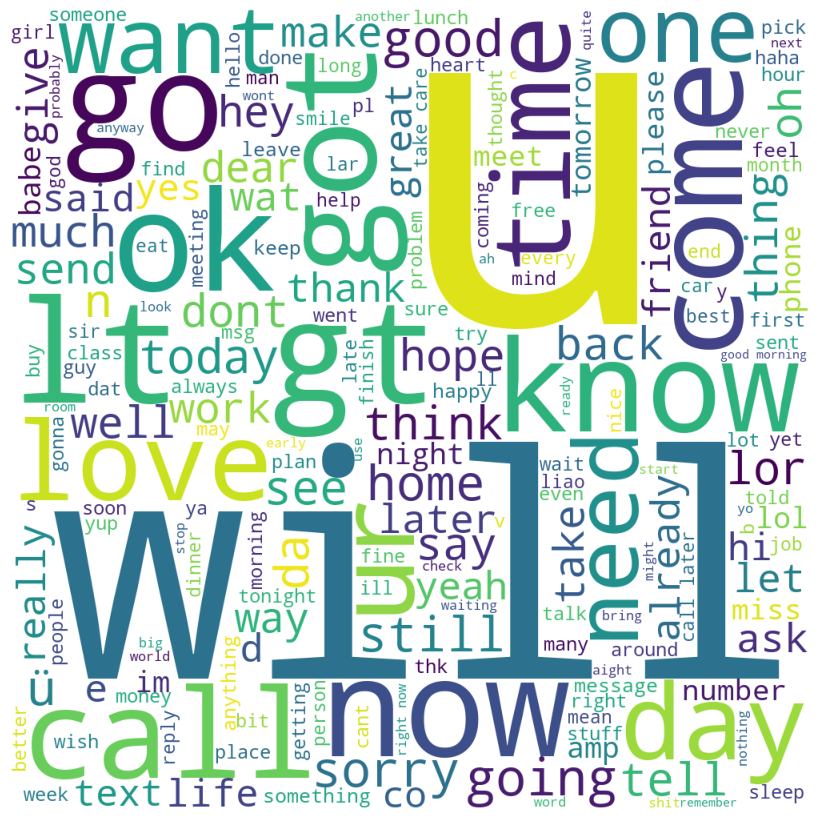

In [18]:
# visualize ham labeled sms
cloud_stopwords = set(STOPWORDS)
ham_words = collect_words(data, label="ham")

print("Total words {}".format(len(ham_words)))

wordcloud = WordCloud(
    width=1000,
    height=1000,
    background_color="white",
    stopwords=cloud_stopwords,
    min_font_size=10,
).generate(ham_words)

# plot the WordCloud image
plt.figure(figsize=(15, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

- As you can see in the legit messages, the most frequent words are will, gt, now, ok, call, want, got, and so on.

- Now we can visualize the most frequent words in messages labeled as spam.

Total words 104304


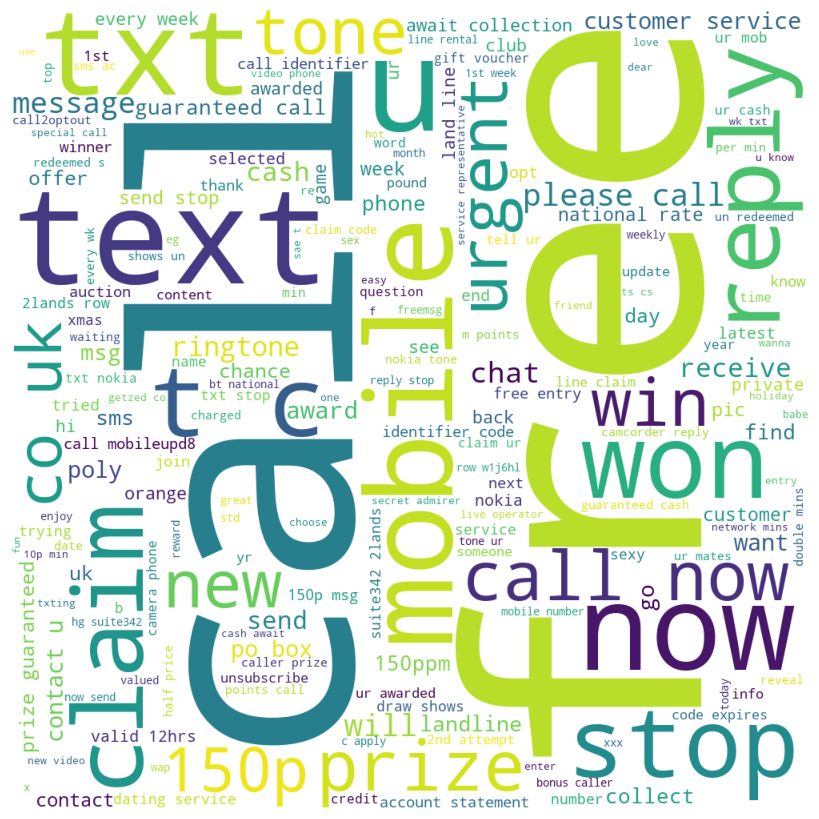

In [19]:
# visualize spam labeled sms
cloud_stopwords = set(STOPWORDS)
spam_words = collect_words(data, label="spam")

print("Total words {}".format(len(spam_words)))

wordcloud = WordCloud(
    width=1000,
    height=1000,
    background_color="white",
    stopwords=cloud_stopwords,
    min_font_size=10,
).generate(spam_words)

# plot the WordCloud image
plt.figure(figsize=(10, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

- In the above figure it shows that the most frequent words are those like call, claim, free, txt, mobile, reply, offer and so on.

In [21]:
# show spam messages
data[data["label"] == "spam"].sample(10)

,label,message,length,punct
879,spam,U have a secret admirer who is looking 2 make ...,132,3
3860,spam,Win the newest Harry Potter and the Order of ...,138,5
3167,spam,HOT LIVE FANTASIES call now 08707509020 Just 2...,101,3
1069,spam,Someone U know has asked our dating service 2 ...,134,3
2220,spam,You have WON a guaranteed £1000 cash or a £200...,154,2
3382,spam,"complimentary 4 STAR Ibiza Holiday or £10,000 ...",149,4
2850,spam,YOUR CHANCE TO BE ON A REALITY FANTASY SHOW ca...,151,3
1940,spam,More people are dogging in your area now. Call...,159,6
5141,spam,FREE for 1st week! No1 Nokia tone 4 ur mobile ...,162,7
2575,spam,Your next amazing xxx PICSFREE1 video will be ...,153,2


In [22]:
# show normal messages
data[data["label"] == "ham"].sample(10)

,label,message,length,punct
4098,ham,i am going to bed now prin,26,0
4549,ham,Hope you are having a good week. Just checking in,49,1
168,ham,"Hi frnd, which is best way to avoid missunders...",74,3
4677,ham,Ü ready then call me...,23,3
4420,ham,How have your little darlings been so far this...,122,4
1315,ham,Got but got 2 colours lor. One colour is quite...,122,5
1348,ham,She doesnt need any test.,25,1
3105,ham,That's y i said it's bad dat all e gals know u...,66,6
112,ham,Going for dinner.msg you after.,31,2
4308,ham,I guess it is useless calling u 4 something im...,54,1


### Processing the Data

In [20]:
# replace ham to 0 and spam to 1
new_data = data.replace({"ham": 0, "spam": 1})
new_data.head()

,label,message,length,punct
0,0,"Go until jurong point, crazy.. Available only ...",111,9
1,0,Ok lar... Joking wif u oni...,29,6
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,6
3,0,U dun say so early hor... U c already then say...,49,6
4,0,"Nah I don't think he goes to usf, he lives aro...",61,2


- The messages in this dataset contain a lot of unnecessary words and characters that we don't need when creating machine learning models.

- We will clean the messages by removing stopwords, numbers, and punctuation. Then we will change words into lower case, and finally convert each word into its base form by using the lemmatization process in the NLTK package.

***The text_cleaning() function will handle all necessary steps to clean our dataset.***

In [23]:
stop_words =  stopwords.words('english')

def text_cleaning(text, remove_stop_words=True, lemmatize_words=True):
    # Clean the text, with the option to remove stop_words and to lemmatize word

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9]", " ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"I'm", "I am", text)
    text = re.sub(r"ur", " your ", text)
    text = re.sub(r" nd "," and ",text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r" tkts "," tickets ",text)
    text = re.sub(r" c "," can ",text)
    text = re.sub(r" e g ", " eg ", text)
    text =  re.sub(r'http\S+',' link ', text)
    text = re.sub(r'\b\d+(?:\.\d+)?\s+', '', text) # remove numbers
    text = re.sub(r" u "," you ",text)
    text = text.lower()  # set in lowercase 
        
    # Remove punctuation from text
    text = ''.join([c for c in text if c not in punctuation])
    
    # Optionally, remove stop words
    if remove_stop_words:
        text = text.split()
        text = [w for w in text if not w in stop_words]
        text = " ".join(text)
    
    # Optionally, shorten words to their stems
    if lemmatize_words:
        text = text.split()
        lemmatizer = WordNetLemmatizer() 
        lemmatized_words = [lemmatizer.lemmatize(word) for word in text]
        text = " ".join(lemmatized_words)
    
    # Return a list of words
    return(text)

- Now we can clean our dataset by using the text_cleaning() function.


In [24]:
#clean the dataset 
new_data["clean_message"] = new_data["message"].apply(text_cleaning)

- We then split our dataset into train and test data. The test size is 15% of the entire dataset.

In [25]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    new_data["clean_message"],
    new_data["label"],
    test_size=0.15,
    random_state=0,
    shuffle=True,
    stratify=data["label"],
)

- The CountVectorizer method from scikit-learn will help us transform our cleaned dataset into numerical values. The method converts a collection of text documents to a matrix of token counts.



In [26]:
# Transform text data 
vectorizer = CountVectorizer(lowercase=False)
vectorizer.fit(X_train)

#transform train data 
X_train_trans = vectorizer.transform(X_train)

#transform test data
X_text_trans = vectorizer.transform(X_test)

### How to Actually Create Our Model
- We will train the Multinomial Naive Bayes algorithm to classify if a message is legitimate or spam. This is one of the most common algorithms used for text classification.

In [27]:
# Create a classifier

spam_classifier = MultinomialNB()

- Then we train our classifier by using cross validation to avoid overfitting.

In [28]:
# Train the model with cross validation
scores = cross_val_score(spam_classifier,X_train_trans,y_train,cv=10,verbose=3,n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   31.8s finished


- Let's see the mean score.

In [30]:
scores.mean()

0.9767713936539371

- The mean of the scores is around 97.68%. Our model performs well, but we can improve its performance by optimizing its hyperparameter values with the Randomized Search method from scikit-learn.

In [31]:
# fine turning model parameters

distribution = {"alpha": [1, 0.1, 0.01, 0.001, 0.0001, 0, 0.2, 0.3]}

grid = RandomizedSearchCV(
    spam_classifier,
    param_distributions=distribution,
    n_jobs=-1,
    cv=10,
    n_iter=20,
    random_state=42,
    return_train_score=True,
    verbose=2,
)

- We will optimize the alpha hyparameter from our model to get the best value that will increase our model's performance.

In [32]:
# training with randomized search
grid.fit(X_train_trans, y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


/Users/gabe/anaconda3/lib/python3.11/site-packages/sklearn/naive_bayes.py:624: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/Users/gabe/anaconda3/lib/python3.11/site-packages/sklearn/naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/Users/gabe/anaconda3/lib/python3.11/site-packages/sklearn/naive_bayes.py:624: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/Users/gabe/anaconda3/lib/python3.11/site-packages/sklearn/naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/Users/gabe/anaconda3/lib/python3.11/site-packages/skl

RandomizedSearchCV(cv=10, estimator=MultinomialNB(), n_iter=20, n_jobs=-1,
                   param_distributions={'alpha': [1, 0.1, 0.01, 0.001, 0.0001,
                                                  0, 0.2, 0.3]},
                   random_state=42, return_train_score=True, verbose=2)

- To show the hyperparameter optimization results:

In [33]:
# summarize the results of the random parameter search
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

0.9767713936539371
MultinomialNB(alpha=1)
{'alpha': 1}


- The best score is the same as the previous one. Now let's test our model with the test data.

In [35]:
# Create a Multinomial Naive Bayes classifier
spam_classifier = MultinomialNB()

# Fit the classifier on your training data (X_train_trans are your training features, y_train is your training labels)
spam_classifier.fit(X_train_trans, y_train)

# Now you can make predictions
y_pred = spam_classifier.predict(X_text_trans)

- The model's performance will be evaluated by using the accuracy_score evaluation metric.

In [36]:
# check accuracy score
accuracy_score(y_test, y_pred)

0.9760765550239234

[CV] END ................................ score: (test=0.975) total time=   0.2s
[CV] END ................................ score: (test=0.983) total time=   0.0s
[CV] END ................................ score: (test=0.977) total time=   0.0s
[CV] END ................................ score: (test=0.970) total time=   0.0s
[CV] END ................................ score: (test=0.975) total time=   0.0s
[CV] END ............................................alpha=1; total time=   0.0s
[CV] END ............................................alpha=1; total time=   0.0s
[CV] END ............................................alpha=1; total time=   0.0s
[CV] END ............................................alpha=1; total time=   0.0s
[CV] END ............................................alpha=1; total time=   0.0s
[CV] END ............................................alpha=1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ...................

- The accuracy of our model is around 97.6%, which is good performance.

- Another useful evaluation metric to use is f1_score when you have a class imbalance in your dataset.

In [37]:
# check f1_ score
f1_score(y_test, y_pred)

0.908256880733945

- The score is 0.91 which is closer to 1. This means that our model has good performance and we can now deploy it to production.

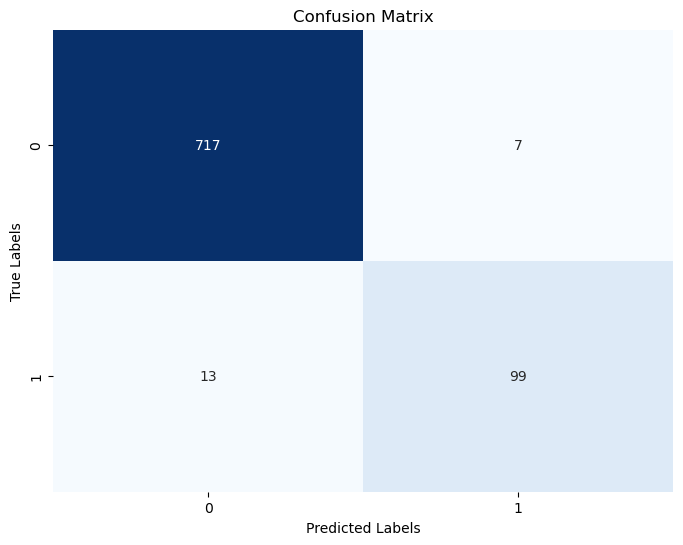

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Model Deployment

- The model will be saved in models directory.

In [40]:
import joblib

# Specify the path where you want to save the model
model_path = "models/spam-detection-model.pkl"

# Save the model to the specified path
joblib.dump(spam_classifier, model_path)

['models/spam-detection-model.pkl']

- Our  Count Vectorizer will also be saved in the preprocessing directory.

In [41]:
# Specify the path where you want to save the Count Vectorizer
vectorizer_path = "preprocessing/count_vectorizer.pkl"

# Save the Count Vectorizer to the specified path
joblib.dump(vectorizer, vectorizer_path)


['preprocessing/count_vectorizer.pkl']

- After creating our spam detection model, it's time to deploy it on the Algorithmia platform.